# Data Preparation

This notebook contains the code to generate the base datasets for later estimation. Steps include;

   1. Removing people who do not meet the inclusion criteria (age at wave1, present in both intial and final wave). 
   2. Computing treatment and outcome variables.
   3. Removing features that are deemed to be proxies for the treatment variable
   4. Removing columns that are ids or otherwise deemed irrelevant.
   5. Optional unsupervised feature selection (with respect to the treatment/target) feature selection to produce smaller datasets and reduce the issue of correlated features.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyreadstat
import re
import string
#from sklearn_pandas import DataFrameMapper
import networkx as nx
import reed, config
import pickle
from clean import *
from reed import regex_select

pd.options.display.max_columns=100
pd.options.display.max_colwidth=200
%load_ext autoreload
%autoreload 2

from platform import python_version

print(python_version())
import sys
print(sys.executable)

%matplotlib inline

3.9.7
/home/dsteinberg/.virtualenvs/re-education/bin/python


## Parameters
Set which waves to base the analysis on, what the minimum age must be to be considered and above what threshold a column is excluded due to missing data.

In [2]:
s,m,e = 'a','q','s' # select which waves to base analysis on
min_start_age = 25 # the minimum age people must as of the starting wave
missing_threshold = 0.90
correlation_threshold = 0.90
redundant_threshold=0.9
test = False
release = config.release

## Data Structure

- Part1 contains the combined data from all questionairs asked in a given wave. Each wave is a separate file (eg a s wave 1, be is wave 2, etc. 

### Filter people who were already studying

In [3]:
summary_study = ['aedqstdy','aedfts','acaeft','acaept','anlreast','abncsty','abnfsty']

c11_study = [
 'aedcqsl',
 'aedcqsh',
 'aedcqnq',
 'aedcqtq',
 'aedcqta',
 'aedcqtc',
 'aedcqc1',
 'aedcqc2',
 'aedcqc3',
 'aedcqc4',
 'aedcqcd',
 'aedcqad',
 'aedcqav',
 'aedcqbd',
 'aedcqhd',
 'aedcqgd',
 'aedcqms',
 'aedcqdc',
 'aedcqbc',
 'aedcqsc',
 'aedcqcc',
 'aedcqgc',
 'aedcqcn',
 'aedcqdn',
 'aedcqnei',
 'aedcqna',
 'aedcqos',
 'aedcqdk',
]

dv_asced_study = [
 'aedcq100',
 'aedcq110',
 'aedcq120',
 'aedcq200',
 'aedcq211',
 'aedcq221',
 'aedcq310',
 'aedcq311',
 'aedcq312',
 'aedcq400',
 'aedcq411',
 'aedcq413',
 'aedcq421',
 'aedcq500',
 'aedcq511',
 'aedcq514',
 'aedcq521',
 'aedcq524',
 'aedcq600',
 'aedcq611',
 'aedcqunk'
]

already_studying_cols = summary_study + c11_study + dv_asced_study

def filter_participants(df1,min_start_age, already_studying_cols):
    """
    Remove those already studying or below the minimum age in the initial wave.
    """
    n0 = len(df1)
    df = df1.loc[df1[f'{s}hgage'] >= min_start_age].copy()
    print(f"Dropping {n0-len(df)} participants below age {min_start_age}")

    # filter out those already studying

    already_studying = df[already_studying_cols].sum(axis=1)

    n0 = len(df)
    df = df[already_studying < 1].copy()
    print(f"Dropping {n0-len(df)} participants already studying at period start")
    print(f"Remaining participants:{len(df)}")
    return df


# read the combined file for the starting wave
sfx = config.release_suffix[release]
df1, meta1 = pyreadstat.read_sav(f'data/part1/Combined {s}190{sfx}.sav')
n0 = len(df1)
print(f"Number of people in initial wave {n0}")
with open('data/metadata.pkl','wb') as f:
    pickle.dump(meta1,f)
    
df1 = filter_participants(df1,min_start_age, already_studying_cols)

Number of people in initial wave 19914
Dropping 7359 participants below age 25
Dropping 1387 participants already studying at period start
Remaining participants:11168


### Compute treatment & outcomes
#### Outcomes measures
   - **hours worked** Largly missing. The following variables are perfectly correlated
      - `ajbhru` 57% missing, *E1b Hours per week usually worked in all your jobs*
      - `ajbhruc`,57% missing *DV: Hours per week usually worked in all jobs*
   - **wages (not normalised by hours worked)**
      - `awsfe` wages from all jobs last financial year with imputation from net
      - `awsce` current weekly wages from all jobs with imputation from net
      - Non-imputed versions of both of these exist (replace the final `e` with `g`) but have slightly more missing values
      - `awsfhave` records if people have received income from salary/wages last financial year. We could also use `_esbrd` to tell if people should have a non-zero wage.
      - wage variables have quite a lot of missing data (~33% missing `awsfe` and 30% missing both `awsfe` and `awsfhave`)
      - There are versions of wage variables with imputation of missing data from based on responses from the participant in other waves and responses from similar participants. These are indicated by the suffix `i` (eg `awsfei`, `awscei`). These variables contain no missing data.
   - **employment status (categorical outcome)**
   - **mental health**
   
#### Treatment measures
   - Treatment is based on a change in education qualification between 2001 and 2017
   - There are a number of study related variables that are only recorded on a subset of the waves. 
   - _edq{XXX} variables are recorded every year and count the number of qualifications a person holds in each of a number of categories


In [4]:
from treatment_outcomes import compute_treatment_vars, compute_outcomes
treatments = compute_treatment_vars(df1, s, m, release)
outcomes = compute_outcomes(df1, s, e, release)
treatment_outcomes = pd.merge(treatments,outcomes,on='xwaveid',how='inner')
treatment_outcomes['xwaveid'] = treatment_outcomes['xwaveid'].astype(int)
print("Treatments:",treatments.columns)
print("Outcomes:",outcomes.columns)
print("Updated computation of treatment")

Treatments: Index(['xwaveid', 'redudl', 'reduhl', 'redufl'], dtype='object')
Outcomes: Index(['xwaveid', 'y_jbhruc', 'y_ghmh', 'y_wsce', 'y_wscei', 'y_employment',
       'y_Djbhruc', 'y_Dghmh', 'y_Dwsce', 'y_Dwscei', 'y_Demployment'],
      dtype='object')
Updated computation of treatment


#### Confusion matrix for highest vs count based treatment variable

In [5]:
from reed import compute_confusion
compute_confusion(treatments['redudl'],treatments['reduhl'],'dl','dh')

,dh==0,dh==1
dl==0,4460,3
dl==1,914,557


## Extract basic variables
Extract a data set corresponding to the original paper we are working to extend - based on the table below;
![image.png](images/original_paper_table.png)

In [6]:
from treatment_outcomes import simplify_employment
from reed import regex_select

def extract_basic_variables(df):
    # age, sex, education in 2001, employment status in 2001
    basic = df1[['xwaveid','ahgage','ahgsex','aedhigh1','aesdtl']].copy() 

    def simplify_education(v):
        """Simplify down to match categories in paper."""
        if v < 0 or v==10:
            return np.nan # missing
        if v < 3: #(above bachelors)
            return 2
        return v # < year 12:(9), year 12:(8), cert:(5), diploma/adv diploma:(4), bachelors/honours:(3)
    
    # simplify education & employment in line with baseline paper
    basic['aesdtl']=basic['aesdtl'].apply(simplify_employment)
    basic['aedhigh1'] = basic['aedhigh1'].apply(simplify_education)
    
    # bin age
    basic['ahgage'] = pd.cut(basic['ahgage'],bins=[24,34,44,54,120])
    
    # dummy encode
    basic = pd.get_dummies(basic,columns=['ahgage','ahgsex','aedhigh1','aesdtl'],drop_first=True)
    
    # add interactions between gender and other variables
    age_edu_emp = regex_select(basic.columns,['^ahgage_','^aedhigh1_','^aesdtl_'])
    basic = create_interaction_columns(basic,['ahgsex_2.0'],age_edu_emp)
    basic['xwaveid'] = basic['xwaveid'].astype(int)
    return basic

if not test:
    basic = extract_basic_variables(df1)
    l0 = len(basic)
    basic_with_outcomes = pd.merge(basic,treatment_outcomes,on='xwaveid',how='inner')
    l1 = len(basic_with_outcomes)
    print(f"Dropped {l0-l1} individuals who are not present in waves {m} and {e} ({100*(l0-l1)/l0:.0f}%)")
    basic_with_outcomes.set_index('xwaveid',inplace=True)
    basic_with_outcomes.to_csv("data/basic_variables.csv",index=True)

Dropped 5727 individuals who are not present in waves q and s (51%)


## Extract Full variable set
Extract a 'kitchen sink' dataset with minimal filtering of features

### Filter out columns based on annotated spreadsheet
Remove columns that have been manually marked as irrelevant or proxies to whether someone is already studying. 

In [7]:
def read_type_information():
    headers = ['variable','vartype','format','label','long_label','varcat','relevance',"0"]
    type_df = pd.read_csv("data/HILDAw1vardic.csv",skiprows=4,index_col=None, names=headers)
    type_df['relevance'] = type_df['relevance'].fillna(1).astype(int)
    type_df.loc[type_df['label']=='ACAEPT','relevance'] = -1
    return type_df

def drop_irrelevant_columns_inplace(df, type_df):
    irrelevant = list(type_df.loc[type_df['relevance']<1,'variable'])
    irrelevant.remove('xwaveid')
    df.drop(columns=irrelevant,inplace=True)
    print(f"Dropped {len(irrelevant)} irrelevant columns.")
    return irrelevant

### Fix types
   - encode categorical values & strings as integers (ordinal rather than one-hot)
   - transform dates into days past 01/01/1900

In [8]:
def fix_types_inplace(df1):
    # Reformat some of the columns
    dates = [
        "ahhhqivw",
        "ahhcompi",
        "ahhcompf",
        "ahhcomps",
        "ahhidate",
        "ahgdob1",
        "ahgdob2",
        "ahgdob3",
        "ahgdob4",
        "ahgdob5",
        "ahgdob6",
        "ahgdob",
    ]
    string = ['ahhtitle']
    categorical = [
        'acca1',
        'acca2',
        'ahhmgfxd',
        'ahhmgmxd',
        'ahhp1',
        'ahhp2',
        'ahhp3',
        'ahhpgfxd',
        'ahhpgmxd',
        'ahhpno',
        'xwaveid',
        'ahhid',
        'ahhpid',
        'ahhpcode',
        'ahharea',
        'ahhcd96',
        'ats1',
        'ats2',
        'ats3',
        'ats4',
        'ats5',
        'ats6',
        'ahhdw',
        'acsid1',
        'acsid2',
        'acsid3',
        'acsid4',
        'acsid5',
        'acsid6',
        'achid1',
        'achid2',
        'achid3',
        'achid4',
        'achid5',
        'achid6',
        'acpid1',
        'acpid2',
        'acpid3',
        'acpid4',
    ]

    for c in categorical:
        if c in df1.columns:
            df1[c] = df1[c].replace("--", "")
            df1[c] = pd.to_numeric(df1[c])

    # turn into days past epoch
    basedate = pd.to_datetime('01/01/1900',format='%d/%m/%Y')    
    for c in dates:
        if c in df1.columns:
            df1[c] = (pd.to_datetime(df1[c],format='%d/%m/%Y',errors='coerce')-basedate).dt.days 

    for c in string:
        df1[c] = df1[c].astype('category').cat.codes

In [9]:
def redundancy_with_nan(series, nbins):
    """
    Compute the redundancy of a series after binning.
    
    Redundancy, in [0,1], measures how close the entropy of the distribution is to the maximum
    entropy given the number of bins. Redundancy is minimized (=0) when the data is uniformly 
    distributed over the bins and maximised (=1) when all the data is in a single bin. 
    """
    if series.nunique() > nbins:
        series = pd.cut(series, nbins, labels=False)
            
    counts = series.value_counts(dropna=False).values
    if len(counts) == 1:
        return 1
    p = counts/counts.sum()
    entropy = (-p*np.log(p)).sum()
    redundancy = 1 - entropy/np.log(len(counts))
    return redundancy

def drop_redundant_columns_inplace(df,nbins, threshold):
    r = np.zeros(len(df.columns))
    for i,c in enumerate(df.columns):
        r[i] = redundancy_with_nan(df[c],nbins)
    
    exclude = r > threshold
    redundant = list(df.columns[exclude])
    
    r_values = dict(zip(df.columns[~exclude],r[~exclude]))
    
    df.drop(columns=redundant,inplace=True)
    print(f"Dropped {len(redundant)} columns with high redundancy/low entropy")
    return redundant, r_values

In [10]:
def compute_correlations(df, fillval = 0):
    """Compute the correlations between each pair of variables and return as a DataFrame in long form."""
    c = df.fillna(fillval).corr()
    c1 = []
    c2 = []
    value = []
    for i in range(c.shape[0]):
        for j in range(c.shape[0]):
            if i > j:
                value.append(c.iloc[i, j])
                c1.append(c.index[i])
                c2.append(c.columns[j])
    c = pd.DataFrame({'c1': c1, 'c2': c2, "correlation": value})
    c['abs'] = c['correlation'].abs()
    c.sort_values(['abs'],ascending=False,inplace=True)
    return c

In [11]:
from collections import defaultdict

def merge_correlated_pairs(df,r_vals, threshold, fillval=0):
    """
    Merges pairs of variables with a correlation coefficient above the threshold.
    
    Returns
    -------
    merged: list[str]
        A list of all the column names that were merged into other columns.
        
    merges: {str:[str]} 
        A dict from column name to all the columns merged with that column.
    """

    cs = compute_correlations(df, fillval)
    
    column_indicies = [
        cs.columns.get_loc('c1'),
        cs.columns.get_loc('c2'),
        cs.columns.get_loc('abs')
    ]

    row = cs.iloc[0,column_indicies]
    c1, c2, t = row
    merges = defaultdict(list)
    while t >= threshold:

        # merge (keep lowest redundancy)
        r1, r2 = r_vals[c1], r_vals[c2]
        if r1 <= r2:
            best, other = c1, c2
        else:
            best, other = c2, c1

        merges[best].append(other)

        # delete all rows involving merged in variable
        drop_index = cs.index[(cs['c1']==other)|(cs['c2']==other)]

        cs.drop(index=drop_index,inplace=True)
        row = cs.iloc[0,column_indicies]
        c1, c2, t = row
    
    merged = []
    for v in merges.values():
        merged.extend(v)
        
    df.drop(columns=merged,inplace=True)
    return merged, merges

### Automatic (very basic) column filtering
   - drop columns where the proportion of data missing is above the maximum threshold
   - drop columns that are constant (zero variance)
   - drop columns that are very tightly correlated (based on correlation threshold) with another column that contains less missing data. 

In [12]:
def filter_raw_data(df1, missing_threshold=0.99, correlation_threshold=0.99):
    columns_dropped = {} # keep track of why each column was dropped
    
    type_df = read_type_information()
    irrelevant = drop_irrelevant_columns_inplace(df1,type_df)
    add_list_to_dict(irrelevant,columns_dropped,'invalid/irrelevant')

    fix_types_inplace(df1)
    
    constant = drop_constant_columns(df1)
    add_list_to_dict(constant,columns_dropped,'constant')
    
    if redundant_threshold < 1:
        redundant, r_vals = drop_redundant_columns_inplace(df1, 100, redundant_threshold)
        add_list_to_dict(redundant,columns_dropped,'high-redundancy')
    
    if missing_threshold < 1:
        mostly_missing = drop_mostly_missing_columns(df1, threshold = missing_threshold)
        add_list_to_dict(mostly_missing, columns_dropped, 'mostly-missing')
    
    if correlation_threshold < 1:
        dropped, merges = merge_correlated_pairs(df1, r_vals, correlation_threshold,fillval=0)
        add_list_to_dict(dropped, columns_dropped, 'merged')
    
    
    print("Processed data, with shape:",df1.shape)
    return df1, columns_dropped, r_vals


### Save the data to file
Save the data to file for subsequent model fitting

In [13]:
import os
def write_data(X, treatment_outcomes,filename):
    filepath = os.path.join("data",filename)
    l0 = len(X)
    df = pd.merge(X, treatment_outcomes, on=['xwaveid'],how='inner')
    l1 = len(df)
    print(f"Dropped {l0-l1} individuals who are not present in waves {m} and {e} ({100*(l0-l1)/l0:.0f}%)")
    df.set_index('xwaveid',inplace=True)
    df.to_csv(filepath,index=True)
    print(f"Written data of shape {df.shape} to:",filepath)
    assert (basic_with_outcomes.index == df.index).all(), "index should be the same across datasets"

if not test:
    X, columns_dropped, r_vals = filter_raw_data(df1.copy(), missing_threshold=missing_threshold,correlation_threshold=correlation_threshold)
    write_data(X, treatment_outcomes, "all_vars.csv")

Dropped 403 irrelevant columns.


/home/dsteinberg/code/re-education/clean.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  std = df.std()


Dropping 269 columns that are constant or entirely missing
Dropped 1879 columns with high redundancy/low entropy
Dropping 385 columns with more than 90% missing 
Processed data, with shape: (11168, 845)
Dropped 5727 individuals who are not present in waves q and s (51%)
Written data of shape (5441, 857) to: data/all_vars.csv


## Feature selection using wage 5 years after initial wave as labels

This is based on the premise that the features that are predictive of the change in wage due to returning to education are likely to be the same set of features that are important for predicting wage more generally. This allows us to do supervised feature selection without worrying so much about over-fitting to the data, as we are not using the final labels we are training against. 

Note: we can't use initial wage as the target because then we end up selecting features that are simply proxies to the target.

In [14]:
from cinspect.dimension import effective_rank
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression
from sklearn.preprocessing import StandardScaler
import string

In [16]:
# Make a dataset for feature selection that uses the value of the target feature 5 years after the initial wave as the target

def create_dataset_to_predict_outcome_five_years_after_initial_wave(target):
    indx = string.ascii_lowercase.index(s)+5
    post_start = string.ascii_lowercase[indx]
   
    df0, meta1 = pyreadstat.read_sav(f'data/part1/Combined {s}190{sfx}.sav') 
    outcomes_post = compute_outcomes(df0, s, post_start, release)
    outcomes_post['xwaveid'] = outcomes_post['xwaveid'].astype(int)
    outcomes_post.set_index('xwaveid',inplace=True)
    X, columns_dropped, r_vals = filter_raw_data(df0, missing_threshold=0.9,correlation_threshold=0.9)
    X['xwaveid'] = X['xwaveid'].astype(int)
    X.set_index('xwaveid',inplace=True)
    o = outcomes_post.join(X)
    features = df0.columns
    y = o[target].values
    valid_rows = ~np.isnan(y)

    y = y[valid_rows]
    X = o.loc[valid_rows,features]
    Xs = StandardScaler().fit_transform(X.fillna(0))
    Xs = pd.DataFrame(Xs, columns=features)
    return Xs, y

if not test:
    target = 'y_wscei'
    Xs, ys = create_dataset_to_predict_outcome_five_years_after_initial_wave(target)

Dropped 403 irrelevant columns.


/home/dsteinberg/code/re-education/clean.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  std = df.std()


Dropping 309 columns that are constant or entirely missing
Dropped 1769 columns with high redundancy/low entropy
Dropping 395 columns with more than 90% missing 
Processed data, with shape: (19914, 855)


### Univariate features selectiong: Select k-best

Takes no account of correlation between features, results in a matrix with a low effective rank (compared with it's actual rank). 

In [17]:
if not test:
    selector = SelectKBest(f_regression, k=10)
    selector.fit(Xs,ys)
    effective_rank(Xs[selector.get_feature_names_out()])

/home/dsteinberg/.virtualenvs/re-education/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


### Multivariate-feature selection: Lasso

/home/dsteinberg/.virtualenvs/re-education/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.484e+08, tolerance: 6.560e+05
  model = cd_fast.enet_coordinate_descent(
/home/dsteinberg/.virtualenvs/re-education/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.010e+08, tolerance: 6.560e+05
  model = cd_fast.enet_coordinate_descent(
/home/dsteinberg/.virtualenvs/re-education/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of 

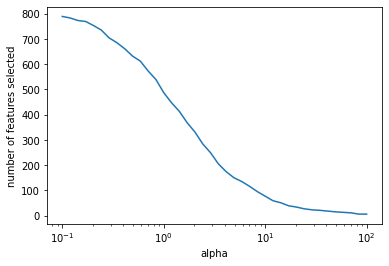

In [18]:
# see how many features we get as a function of regularisation strength. 
# we could use prediction accuracy as a rough estimate of how many features to use
# note that we are not removing people currently studying, so the model may select features relating to current study
# these will be dropped before being written as they are constant. 
from sklearn.linear_model import Lasso, LassoCV
from sklearn.feature_selection import SelectFromModel
if not test:
    alphas = np.logspace(-1,2,40)  
    n_selected = []
    for alpha in alphas:
        ls = Lasso(alpha=alpha)
        selector = SelectFromModel(ls)
        selector.fit(Xs,ys)
        n_selected.append(len(selector.get_feature_names_out()))

    plt.semilogx(alphas, n_selected)
    plt.xlabel("alpha")
    plt.ylabel("number of features selected")

In [19]:
def get_alpha_for_num_features(num_features, n_selected, alphas):
    n_selected = np.array(n_selected)
    indx = np.nanargmin(np.abs(n_selected - num_features))
    return alphas[indx], n_selected[indx]

def select_features(num_features, n_selected, alphas, Xs, ys):
    print(f"Generating dataset with approximately {num_features} features" )
    alpha, _ = get_alpha_for_num_features(num_features,n_selected, alphas)
    ls = Lasso(alpha=alpha)
    selector = SelectFromModel(ls)
    selector.fit(Xs,ys)
    f_selected = selector.get_feature_names_out()
    print("number of features selected:",len(f_selected))
    print("effective rank on selection matrix:",effective_rank(Xs[f_selected]))

    print("\n")
    return f_selected

def write_selected_featureset(X, columns_dropped, features, tag):
    selection = ['xwaveid']
    missing = []
    for f in features:
        if f in X.columns:
            selection.append(f)
        else:
            reason = columns_dropped.get(f,"unkown")
            print(f"Column {f} not present in X, reason:{reason}")
    
    write_data(X[selection], treatment_outcomes, f"all_lasso_selected_{tag}.csv")

In [20]:
if not test:
    f10 = select_features(10, n_selected, alphas, Xs, ys)
    f20 = select_features(20, n_selected, alphas, Xs, ys)
    f50 = select_features(50, n_selected, alphas, Xs, ys)
    f100 = select_features(100, n_selected, alphas, Xs, ys)

    X, columns_dropped, r_vals = filter_raw_data(df1.copy(), missing_threshold=0.99,correlation_threshold=1)

    write_selected_featureset(X, columns_dropped, f10, 10)
    write_selected_featureset(X, columns_dropped, f20, 20)
    write_selected_featureset(X, columns_dropped, f50, 50)
    write_selected_featureset(X, columns_dropped, f100, 100)
    for f in f20:
        print(f, meta1.column_names_to_labels.get(f))

Generating dataset with approximately 10 features
number of features selected: 11
effective rank on selection matrix: 5.955208107031399


Generating dataset with approximately 20 features
number of features selected: 21
effective rank on selection matrix: 10.961410967696544


Generating dataset with approximately 50 features
number of features selected: 51
effective rank on selection matrix: 24.616498296346048


Generating dataset with approximately 100 features
number of features selected: 95
effective rank on selection matrix: 47.00943127122669


Dropped 403 irrelevant columns.


/home/dsteinberg/code/re-education/clean.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  std = df.std()


Dropping 269 columns that are constant or entirely missing
Dropped 1879 columns with high redundancy/low entropy
Dropping 0 columns with more than 99% missing 
Processed data, with shape: (11168, 1741)
Dropped 5727 individuals who are not present in waves q and s (51%)
Written data of shape (5441, 24) to: data/all_lasso_selected_10.csv
Column acapeft not present in X, reason:constant
Column aedfts not present in X, reason:constant
Dropped 5727 individuals who are not present in waves q and s (51%)
Written data of shape (5441, 32) to: data/all_lasso_selected_20.csv
Column aedqstdy not present in X, reason:constant
Column acapeft not present in X, reason:constant
Column aedfts not present in X, reason:constant
Dropped 5727 individuals who are not present in waves q and s (51%)
Written data of shape (5441, 61) to: data/all_lasso_selected_50.csv
Column aedqstdy not present in X, reason:constant
Column acapeft not present in X, reason:constant
Column acapept not present in X, reason:constan

## Unsupervised feature selection

Greedy selection of features to optimise effective rank.

In [ ]:
# from cinspect.dimension import greedy_feature_selection, effective_rank

# features_to_select = 100
# Xs = StandardScaler().fit_transform(X.fillna(0))
# selected, vals = greedy_feature_selection(
#     Xs, effective_rank, 
#     initial_col=4, num_to_select=features_to_select
# )

# selected_cols = [X.columns[i] for i in selected]
# X_su = X[selected_cols]
# print("number of features selected:",len(selected_cols))
# print("effective rank:",effective_rank(Xs[selected]))
# write_data(X_su.reset_index(), treatment_outcomes, "all_unsupervised_selected.csv")